UNZIPPING THE TRAINING DATASET

In [2]:
import zipfile
import os

zip_path = "/content/train.zip"  # Change this if your file has a different name
extract_path = "/content/train_ds"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted files:")
os.listdir(extract_path)


Extracted files:


['train']

LOADING DATASET

In [4]:
import tensorflow as tf

# Set path to your extracted 'train' folder
data_dir = "/content/train_ds/train"

# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,      # 80% training, 20% validation
    subset="training",
    seed=42,
    image_size=(128, 128),     # Resize all images to 128x128
    batch_size=32              # Number of images per batch
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=32
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [5]:
# Save class names before mapping
class_names = train_ds.class_names


NORMALIZATION

In [7]:
from tensorflow.keras import layers

# Rescale pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))


VISUALIZATION

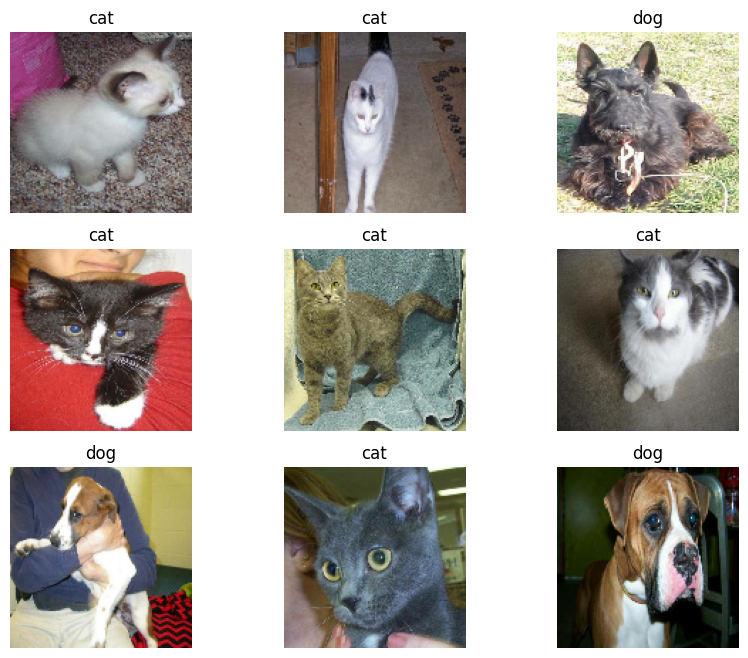

In [8]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):  # take 1 batch
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis("off")


AUGMENTATION

In [18]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


ARCHITECTURE

In [22]:
from tensorflow.keras import layers, models

model = models.Sequential([

    layers.Input(shape=(128, 128, 3)),  # First layer defines the input shape
   data_augmentation,  # Apply data augmentation before training
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),  # Prevent overfitting

    layers.Dense(1, activation='sigmoid')  # Binary output (0 or 1)
])

# Display model architecture
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

COMPILATION

In [23]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


TRAINING MODEL

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop after 2 epochs of no improvement
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.9198 - loss: 0.1945 - val_accuracy: 0.9052 - val_loss: 0.2363
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.9275 - loss: 0.1787 - val_accuracy: 0.8998 - val_loss: 0.2448
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.9241 - loss: 0.1877 - val_accuracy: 0.9026 - val_loss: 0.2351
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 39s 36ms/step - accuracy: 0.9240 - loss: 0.1878 - val_accuracy: 0.9066 - val_loss: 0.2349
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9242 - loss: 0.1816 - val_accuracy: 0.9050 - val_loss: 0.2345
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9278 - loss: 0.1784 - val_accuracy: 0.9030 - val_loss: 0.2355
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.9269 - loss: 0.1768 - val_accuracy: 0.9094 - val_loss: 0.2283
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.9245 - loss: 0.1801 - 

LOADING TEST DATASET

In [12]:
import zipfile
import os

zip_path = "/content/test.zip"  # Change this if your file has a different name
extract_path = "/content/test_ds"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [13]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/test_ds/test",        # path to your test folder
    image_size=(128, 128),
    batch_size=32
)


Found 300 files belonging to 2 classes.


In [42]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8338 - loss: 38.3416

Test Accuracy: 82.67%


TESTED ON CUSTOM IMAGES

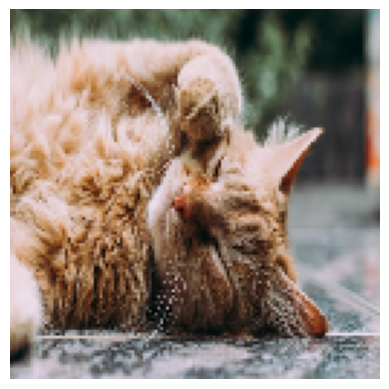

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: cat (0.8659)


In [40]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


img_path = "/content/cat_img.jpg"  # <-- use a valid path from your dataset or upload a new image

img = image.load_img(img_path, target_size=(128, 128))  # same size as used during training
plt.imshow(img)
plt.axis('off')
plt.show()

img_array = image.img_to_array(img)           # Convert to array
img_array = tf.expand_dims(img_array, 0)      # Add batch dimension
img_array = img_array / 255.0                 # Normalize like training data

pred = model.predict(img_array)[0][0]

if pred >= 0.5:
    print(f"Prediction: dog ({pred:.4f})")
else:
    print(f"Prediction: cat ({1 - pred:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


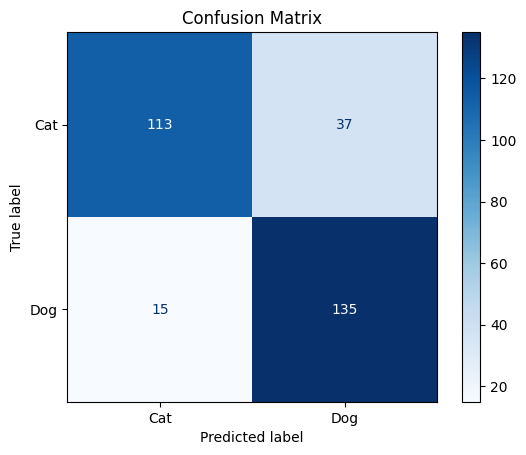

In [43]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Get all true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    predictions = tf.round(predictions).numpy().flatten()  # 0 or 1
    y_pred.extend(predictions)
    y_true.extend(labels.numpy())

# Step 2: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [44]:
model.save("cat_dog_classifier.keras")
